In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import os
import numpy as np
import collections

import scipy.io.wavfile
from scipy.io import loadmat
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
import collections
from scipy.ndimage.interpolation import zoom

import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import frequency


# THEANO: Bengio's Autodiff tensor stuff
import theano
from theano.tensor.nnet import sigmoid
from theano import tensor as T
# LASAGNE: Next abstraction down for NNs
import lasagne
from lasagne import layers
from lasagne.updates import nesterov_momentum, norm_constraint
from lasagne.init import GlorotNormal
from lasagne.objectives import binary_crossentropy
from lasagne.regularization import l2
# NOLEARN: Next abstraction again - to be compatible with Sci-kit learn
import nolearn
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import BatchIterator
# HYPEROPT: randomly search the hyperparameter space for the best ones
from hyperopt import hp, fmin, tpe

import pandas as pd
import numpy as np
import math
import hyperopt

from time import time
from glob import glob
from math import log

from sklearn import metrics
from sklearn.metrics import roc_curve, auc


from time import time

In [2]:
# getting a list of all the files
base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/one_minute_files'
files = os.listdir(base_path + '/detection_challenge')
files = [xx.split('.')[0] for xx in files if 'sampled' not in xx]

spectrogram_parameters = {
    'nfft': 1024,
    'window_width': 0.03,
    'overlap': 0.01,
    }

print len(files)

362


In [3]:
def choose_locations(idxs, maximum, balance=False):
    """
    Given a binary array, the function returns a list of positive and negative locations sampled
    at random from the list.
    Returns 'maximum' locations unless there there are fewer than maximum locations in
    idxs, in which case all are returned
    If balance is true then the classes are balanced to the smaller class size to
    ensure an equal number of each
    """
    false_idxs = np.where(idxs==0)[0]
    true_idxs = np.where(idxs==1)[0]
    
    if false_idxs.shape[0] > maximum and maximum is not None:
        false_idxs = np.random.choice(false_idxs, maximum, replace=False)
        
    if true_idxs.shape[0] > maximum and maximum is not None:
        true_idxs = np.random.choice(true_idxs, maximum, replace=False)
        
    if false_idxs.shape[0] != true_idxs.shape[0] and balance:
        raise Exception("Not implemented!")
        
    return true_idxs, false_idxs
    

def extract_1d_patches(array, locations, hww):
    """
    Extract vertical patches from the array, at the locations given.
    Each slice has a half window width hww
    
    Returns an array of shape:
    (len(locations), array.shape[0], hww*2+1)
    """
    # pad the array to account for overspill
    offset_idxs_np = np.array(locations) + hww
    extra1 = np.tile(array[:, 0], (hww, 1)).T
    extra2 = np.tile(array[:, -1], (hww, 1)).T
    a_temp = np.hstack((extra1, array, extra2))
    
    # set up the array of index locations to extract from
    idxs = [offset_idxs_np]
    for offset in range(1, hww+1):
        idxs.insert(0, offset_idxs_np-offset)
        idxs.append(offset_idxs_np+offset)
    new_idx = np.vstack(idxs).T.ravel()
    
    # extract the patches and do the appropriate reshapgin
    new_shape = (array.shape[0], offset_idxs_np.shape[0], hww*2 + 1)
    to_return = a_temp[:, new_idx].reshape(new_shape).transpose((1, 0, 2))
    return to_return


max_from_each_file = 500
spec_path = '/home/michael/projects/engaged_hackathon_data/detection/spectrograms/'


def process_file(inputs):
    
    count, fname = inputs
    
    # load in wav and convert to spectrogram
    spec = scipy.io.loadmat(spec_path + fname + '_smallspec.mat')['spectrogram']
        
    # load in ground truth
    gt = loadmat(base_path + '/detection_challenge/' + fname + '.mat')
    
    # convert the labels to the sampling rate of the spectrogram
    zoom_factor = float(spec.shape[1]) / float(gt['biotic'][0].shape[0])
    gt_biotic = zoom(gt['biotic'][0], zoom_factor).astype(bool)
    gt_anthrop = zoom(gt['anthropogenic'][0], zoom_factor).astype(bool)
    
    # choosing where to extract from..
    tic = time()    
    true_idxs, false_idxs = choose_locations(gt_biotic, max_from_each_file)
    idxs = np.hstack([true_idxs, false_idxs])
    labels = np.hstack(
        [np.ones(true_idxs.shape), np.zeros(false_idxs.shape)])
    
    # let's group the X here and create a suitable Y vector...
    patches = extract_1d_patches(spec, idxs, hww=9)

    if count % 5 == 0:
        print count,
    
    return patches, labels

print len(files)
XY = map(process_file, enumerate(files))


362
0 5 10 15 20 25 30 35 40 45 50 55 60 65 70 75 80 85 90 95 100 105 110 115 120 125 130 135 140 145 150 155 160 165 170 175 180 185 190 195 200 205 210 215 220 225 230 235 240 245 250 255 260 265 270 275 280 285 290 295 300 305 310 315 320 325 330 335 340 345 350 355 360


X_test (2936, 1, 75, 19) float32
0.0 3.46287 220.502746083
X_train (6012, 1, 75, 19) float32
0.0 6.14807 239.957771956
y_train (6012,) int32
0 1 0.5
y_test (2936,) int32
0 1 0.5


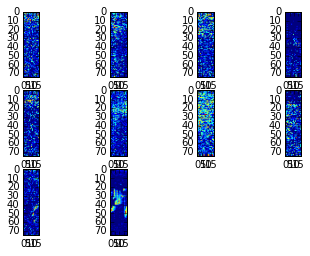

In [36]:
# Do train/test split and combine training data
from sklearn.cross_validation import train_test_split

train_files, test_files = train_test_split(
    range(len(files)), random_state=0, train_size=0.1, test_size=0.05)

tX, tY = zip(*XY)

data = {}
data['X_train'] = np.vstack([tX[idx] for idx in train_files])
data['y_train'] = np.hstack([tY[idx] for idx in train_files]).astype(np.int32)
data['X_test'] = np.vstack([tX[idx] for idx in test_files])
data['y_test'] = np.hstack([tY[idx] for idx in test_files]).astype(np.int32)

for key in ['X_train', 'X_test']:
    tshape = data[key].shape
    data[key] = data[key].reshape((tshape[0], -1, tshape[1], tshape[2]))
    data[key] = data[key].astype(np.float32)

def balance_classes(X, Y):
    positives = np.where(Y == 0)[0]
    negatives = np.where(Y == 1)[0]
    max_examples = min(len(positives), len(negatives))
    
    if len(positives) > max_examples:
        positives = np.random.choice(positives, max_examples, replace=False)
    if len(negatives) > max_examples:
        negatives = np.random.choice(negatives, max_examples, replace=False)
        
    X = np.vstack((X[negatives, :], X[positives, :]))
    new_Y = np.hstack((Y[negatives], Y[positives])) 
    
    shuffle_idxs = np.random.permutation(X.shape[0])
    
    return X[shuffle_idxs, :], new_Y[shuffle_idxs]
    
# balance the classes...
for key in ['train', 'test']:
    data['X_' + key], data['y_' + key] = balance_classes(data['X_' + key], data['y_' + key])
    
for key, val in data.iteritems():
    print key, val.shape, val.dtype
    print val.min(), val.max(), val.sum()/float(val.shape[0])

for idx in range(10):
    plt.subplot(3, 4, idx+1)
    plt.imshow(data['X_train'][idx, 0, :, :])


In [37]:
# Now setting up the CNN


In [38]:
params = (100, log(0.01), log(0.99), 10, 10, 200, 0.5, 50, 5, 5)

hidden_units, learning_rate, momentum, filter1, filter2, batch_size, drop_out, epochs, conv_1, conv_2 = params

# Can also have choice of update (norm_constraint), of non-linearities, of filter sizes, of padding, strides...


def float32(k):
    """
    used for adjust_variables to ensure Theano tensor type compatibility:
    """
    return np.cast['float32'](k)


hidden_units = np.cast['int32'](hidden_units) #150
learning_rate = float32(learning_rate) #0.1
momentum = float32(momentum) #0.9
#patience = np.cast['int32'](patience) #100
filter1 = np.cast['int32'](filter1) #10
filter2 = np.cast['int32'](filter2) #20
batch_size = np.cast['int32'](batch_size) #128
drop_out = float32(drop_out) #0.5
epochs = np.cast['int32'](epochs) #25
conv_1 = np.cast['int32'](conv_1) #3
conv_2 = np.cast['int32'](conv_2) #3
#conv_3 = np.cast['int32'](conv_3) #3
#conv_4 = np.cast['int32'](conv_4) #3

np.random.seed(4)

# data = load_data2()
# todo - train test split proper!


class EarlyStopping(object):
    # from kfkd.py
    def __init__(self, patience=100):
        self.patience = patience
        self.best_valid = np.inf
        self.best_valid_epoch = 0
        self.best_weights = None

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("Early stopping.")
            print("Best valid loss was {:.6f} at epoch {}.".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()

            
class AdjustVariable(object):
    # https://github.com/dnouri/kfkd-tutorial/blob/master/kfkd.py
    """
    Annealing function for learning rate / momentum
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)


In [9]:
# let's load in the mnist dataset and train on that...
def load_mnist(path):
    X = []
    y = []
    with open(path, 'rb') as f:
        next(f)  # skip header
        for line in f:
            yi, xi = line.split(',', 1)
            y.append(yi)
            X.append(xi.split(','))

    # Theano works with fp32 precision
    X = np.array(X).astype(np.float32)
    y = np.array(y).astype(np.int32)

    # apply some very simple normalization to the data
    X -= X.mean()
    X /= X.std()

    # For convolutional layers, the default shape of data is bc01,
    # i.e. batch size x color channels x image dimension 1 x image dimension 2.
    # Therefore, we reshape the X data to -1, 1, 28, 28.
    X = X.reshape(
        -1,  # number of samples, -1 makes it so that this number is determined automatically
        1,   # 1 color channel, since images are only black and white
        28,  # first image dimension (vertical)
        28,  # second image dimension (horizontal)
    )

    return X, y

# here you should enter the path to your MNIST data
path = '/home/michael/learning/cnn/data/mnist/train.csv'
Xmnist, ymnist = load_mnist(path)

In [10]:
ymnist2 = ymnist==0

In [79]:
# net = NeuralNet(
#     layers=[
#         ('input', layers.InputLayer),
#         ('conv1', layers.Conv2DLayer),
#         ('pool1', layers.MaxPool2DLayer),
#         ('dropout1', layers.DropoutLayer),
#         ('conv2', layers.Conv2DLayer),
#         ('pool2', layers.MaxPool2DLayer),
#         ('dropout2', layers.DropoutLayer),
#         ('hidden3', layers.DenseLayer),
#         ('dropout3', layers.DropoutLayer),
#         ('hidden4', layers.DenseLayer),
#         ('output', layers.DenseLayer),
#     ],

# #     input_shape = (None, 1, 75, 19),
#     input_shape = (None, 1, 28, 28),
#     conv1_num_filters=filter1, conv1_filter_size=(conv_1, conv_1), pool1_pool_size=(2, 2),#20
#     conv1_W = GlorotNormal(gain="relu"),
#     dropout1_p=0.1,  # !
#     conv2_num_filters=filter2, conv2_filter_size=(conv_2, conv_2), pool2_pool_size=(2, 2),#50
#     conv2_W = GlorotNormal(gain="relu"),
#     dropout2_p=0.2,  # !
#     hidden3_num_units=hidden_units,
#     hidden3_W = GlorotNormal(gain="relu"),
#     dropout3_p=drop_out,  # !
#     hidden4_num_units=hidden_units,
#     hidden4_W = GlorotNormal(gain="relu"),
#     output_num_units=1,
#     output_nonlinearity=sigmoid,

#     # optimization method:
#     update=nesterov_momentum,
#     update_learning_rate=theano.shared(float32(learning_rate)),
#     update_momentum=theano.shared(float32(momentum)),

#     regression=True,
#     y_tensor_type=T.imatrix,
#     objective_loss_function=binary_crossentropy,

#     on_epoch_finished=[
#         AdjustVariable('update_learning_rate', start=learning_rate, stop=learning_rate / 100),
#         AdjustVariable('update_momentum', start=momentum, stop=0.999),
#         EarlyStopping(5),
#     ],

#     batch_iterator_train=BatchIterator(batch_size),  # 128 is default

#     max_epochs=epochs,
#     verbose=2,

#     # Training test-set split
#     eval_size=0.2
# )
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import objective
from lasagne.layers import get_all_params

train_X = data['X_train']
train_y = data['y_train']
print train_X.shape

# Xmnist
layers0 = [
    # layer dealing with the input data
    (layers.InputLayer, {'shape': (None, train_X.shape[1], train_X.shape[2], train_X.shape[3])}),

    # first stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 5}),
#     (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
#     (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
#     (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (layers.MaxPool2DLayer, {'pool_size': 2}),

    # two dense layers with dropout
    (layers.DenseLayer, {'num_units': 64}),
    (layers.DropoutLayer, {}),
    (layers.DenseLayer, {'num_units': 64}),

    # the output layer
    (layers.DenseLayer, {'num_units': 2 , 'nonlinearity': softmax}),
]

def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but only those that should be regularized
    # (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses


net0 = NeuralNet(
    layers=layers0,
    max_epochs=10,

    update=adam,
    update_learning_rate=0.0002,

    objective=regularization_objective,
    objective_lambda2=0.0025,
    regression=False,
    train_split=TrainSplit(eval_size=0.25),
    verbose=1,
)

# Train the network

net0.fit(train_X, train_y)
#          .astype(np.float32))
# net0.fit(Xmnist[:4154, :, :, :], data['y_train'])

(6012, 1, 75, 19)
# Neural Network with 618658 learnable parameters

## Layer information

  #  name        size
---  ----------  --------
  0  input0      1x75x19
  1  conv2d1     96x71x15
  2  conv2d2     96x69x13
  3  maxpool2d3  96x35x7
  4  conv2d4     128x33x5
  5  conv2d5     128x31x3
  6  conv2d6     128x29x1
  7  maxpool2d7  128x15x1
  8  dense8      64
  9  dropout9    64
 10  dense10     64
 11  dense11     2

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  ------
      1       2.06757       1.78973      1.15524      0.69900  12.30s
      2       1.65097       1.43265      1.15239      0.77127  12.26s
      3       1.35301       1.16846      1.15795      0.81576  12.24s
      4       1.16764       1.02808      1.13575      0.82617  12.23s
      5       1.03907       0.92688      1.12103      0.84136  12.23s
      6       0.94159       0.86076      1.09390      0.84635  12.22s
      7       0.88

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7ff685484ad0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7ff685484a50>,
     custom_score=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 75, 19)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 5, 'num_filters': 96}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'num_filters': 96}), (<class 'lasagne.layers.pool.MaxPool2DLayer'>, {'....layers.dense.DenseLayer'>, {'num_units': 2, 'nonlinearity': <function softmax at 0x7ff685926c08>})],
     loss=None, max_epochs=10, more_params={},
     objective=<function regularization_objective at 0x7ff67d9869b0>,
     objective_lambda2=0.0025,
     objective_loss_function=<function categorical_crossentropy at 0x7ff6854d0aa0>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7ff653dcc170>],
     on_training_finished=[],
     on_

In [80]:
print train_y.shape

(6012,)


In [85]:
#threshold = threshold
yt, pred_yt = data['y_test'], net0.predict_proba(data['X_test'])
# pred_yt = np.array(pred_yt>=0.5, dtype=np.int32)
pred_yt = pred_yt[:, 1]
test_accuracy = metrics.accuracy_score(yt, pred_yt>0.5)

In [86]:
print test_accuracy
print data['X_test'].shape
print pred_yt

0.79053133515
(2936, 1, 75, 19)
[ 0.37593088  0.17630576  0.89904243 ...,  0.20627359  0.08858673
  0.97458649]


In [87]:
print 1.0 - yt.mean()
print yt.shape
print pred_yt.sum()
print train_y.mean()

0.5
(2936,)
1539.52
0.5


In [88]:
print Xmnist.shape
print data['y_train'].shape
print Xmnist.dtype, ymnist.dtype, ymnist2.dtype
print Xmnist.max(), Xmnist.min()

(42000, 1, 28, 28)
(6012,)
float32 int32 bool
2.81644 -0.42463


0.82892673121
[ 0.37593088  0.17630576  0.89904243 ...,  0.20627359  0.08858673
  0.97458649]


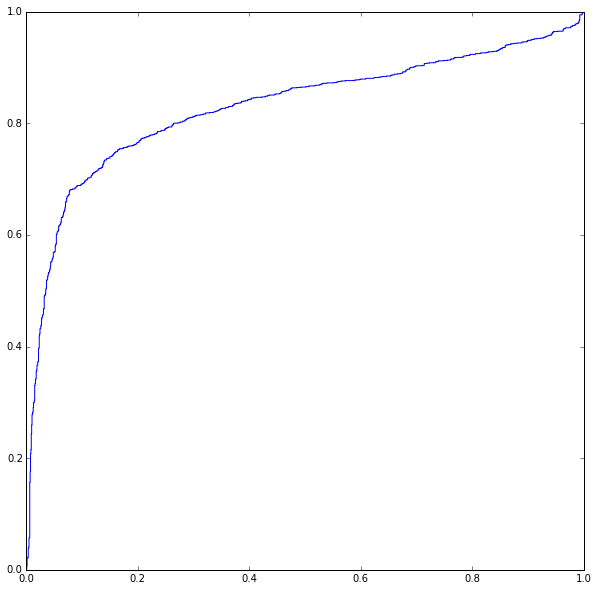

In [89]:
from sklearn.metrics import roc_curve, auc

# Potting an ROC curve for each feature set
aucs = []

plt.figure(figsize=(10, 10))

# plotting this line
fpr, tpr, _ = roc_curve(yt, pred_yt.ravel())
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr , label='(area = %0.2f)' % (roc_auc))
print roc_auc

print pred_yt